In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Tue Jan 16 18:41:12 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   30C    P0    42W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.spiral_prior import Prior
from model.latent.mmd_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.opts = {'pz_scale': 1,
           'mmd_kernel': 'IMQ', # 'IMQ', 'RBF'
            'pz': 'uniform', # 'normal', 'sphere', 'uniform'
            'zdim': hp.z_dim
           }

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.16-7/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 4
-rw-rw-r-- 1 scpark scpark 40  1월 16 18:40 events.out.tfevents.1705397919.GPUSVR11


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


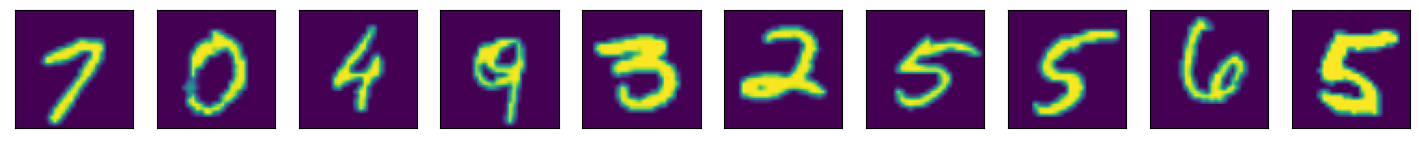

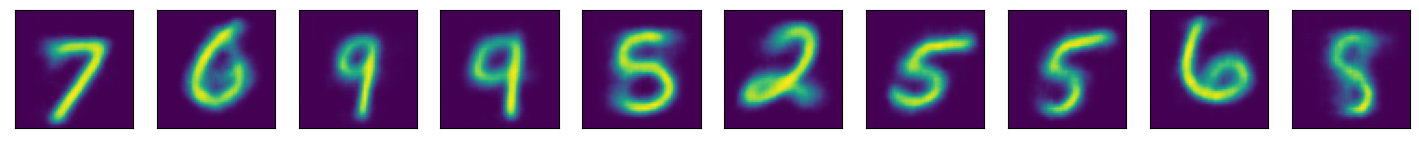

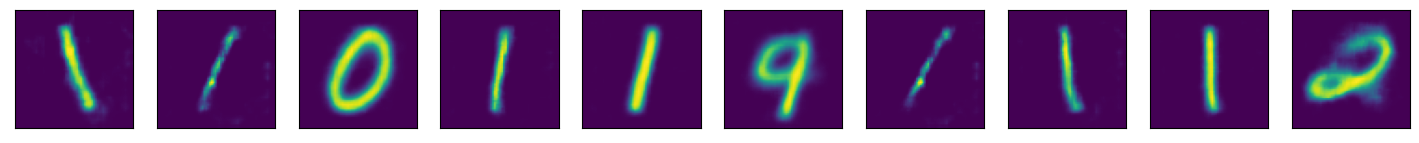

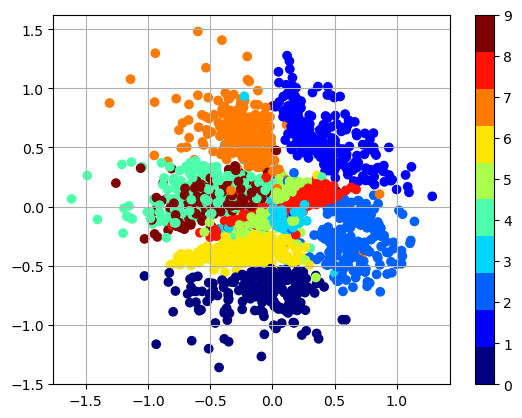

8001
mmd_loss -0.00812767744064331
recon_loss 0.11144144237041473
8002
mmd_loss -0.01066354513168335
recon_loss 0.10721931234002113
8003
mmd_loss -0.009013992547988892
recon_loss 0.10748238861560822
8004
mmd_loss -0.0034733891487121584
recon_loss 0.11744264513254166
8005
mmd_loss -0.00947110652923584
recon_loss 0.11598376631736755
8006
mmd_loss -0.004679149389266968
recon_loss 0.11046115830540656
8007
mmd_loss -0.010796815156936646
recon_loss 0.10500578060746193
8008
mmd_loss -0.007168817520141602
recon_loss 0.10592382028698921
8009
mmd_loss -0.008940845727920532
recon_loss 0.10388792306184769
8010
mmd_loss -0.008352583646774292
recon_loss 0.11129637360572815
8011
mmd_loss -0.005064725875854492
recon_loss 0.10359396785497665
8012
mmd_loss -0.011441326141357422
recon_loss 0.10984207168221474
8013
mmd_loss -0.006649178266525268
recon_loss 0.10227492526173591
8014
mmd_loss -0.004242974519729614
recon_loss 0.10688055381178856
8015
mmd_loss -0.011292868852615356
recon_loss 0.108124820142984

mmd_loss -0.010644453763961791
recon_loss 0.11196684762835503
8125
mmd_loss -0.010526269674301147
recon_loss 0.10724735260009766
8126
mmd_loss -0.0025271117687225343
recon_loss 0.11635488867759705
8127
mmd_loss -0.010069262981414796
recon_loss 0.10572463050484657
8128
mmd_loss -0.010758358240127563
recon_loss 0.11039029434323311
8129
mmd_loss -0.01125190258026123
recon_loss 0.10720552131533623
8130
mmd_loss -0.011200737953186036
recon_loss 0.11141684204339981
8131
mmd_loss -0.008241003751754761
recon_loss 0.10680393800139427
8132
mmd_loss -0.008543717861175536
recon_loss 0.10744064599275589
8133
mmd_loss -0.008276790380477905
recon_loss 0.10598280504345894
8134
mmd_loss -0.009872674942016602
recon_loss 0.11240439563989639
8135
mmd_loss -0.0010986328125
recon_loss 0.10611643567681313
8136
mmd_loss 0.00047229528427124025
recon_loss 0.11156843155622483
8137
mmd_loss -0.011461907625198364
recon_loss 0.1093106135725975
8138
mmd_loss -0.008008158206939698
recon_loss 0.11024731993675232
8139


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        